In [2]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
# from ipywidgets import interactive
%matplotlib inline

from tqdm import tqdm

In [11]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.date == 210922].reset_index()
meta = meta[['mouse','date','area']]

meta.mouse = meta.mouse.astype(int)
meta.date = meta.date.astype(int).astype(str) + '_caiman'
meta = meta.head(1) # multisession, only keep one metadata
meta

,mouse,date,area
0,1339,210922_caiman,V1


In [13]:
nset = len(meta.index); ncell = []; nori = 500; nisi = 1; nframe_trial = 137
dir_name = root_path + 'mat/'

vis_ad = np.empty([0,nori]); 
dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
trace = np.empty([0,nori,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)
    
    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([391], (391, 500), (391, 500), (391, 500), (391, 500, 137))

In [14]:
meta['ncell'] = ncell
meta

,mouse,date,area,ncell
0,1339,210922_caiman,V1,391


In [15]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell.tail()

,mouse,area
386,1339,V1
387,1339,V1
388,1339,V1
389,1339,V1
390,1339,V1


## Adaptation magnitude (no filter by vis ad yet)

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [21]:
adp_mag = dfof_tg / dfof_ad - 1
# adp_mag = adp_mag * vis_ad
adp_mag[adp_mag == 0] = np.nan
adp_mag.shape

(391, 500)

C:\Users\ll357\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\ll357\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


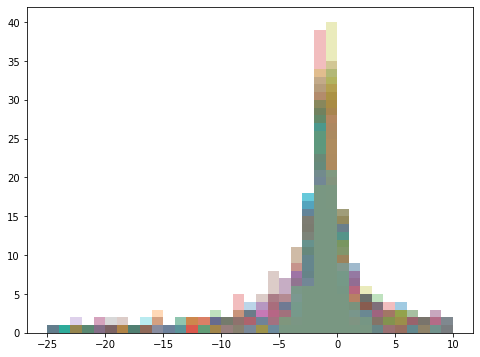

In [17]:
plt.figure(figsize=(8,6))
for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], alpha=0.3)
    plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)

In [22]:
mag = adp_mag.flatten('F')
ad = dfof_ad.flatten('F')
tg = dfof_tg.flatten('F')
stim = [np.arange(nori)] * adp_mag.shape[0]
stim_flat = np.sort([item for sublist in stim for item in sublist])
stim_flat.shape, mag.shape, ad.shape

((195500,), (195500,), (195500,))

In [23]:
df = pd.DataFrame({'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
df

,stim,ad,tg,mag,abs_mag
0,0,0.027267,-0.117640,-5.314363,5.314363
1,0,-0.060858,-0.135916,1.233347,1.233347
2,0,-0.027610,-0.014151,-0.487462,0.487462
3,0,-0.115925,0.000434,-1.003747,1.003747
4,0,-0.234697,-0.056571,-0.758961,0.758961
...,...,...,...,...,...
195495,499,-0.061276,0.018908,-1.308576,1.308576
195496,499,0.011214,-0.017295,-2.542221,2.542221
195497,499,-0.018142,0.000773,-1.042595,1.042595
195498,499,-0.042340,-0.013856,-0.672747,0.672747


In [25]:
mag_mean = df[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
df[['mag','stim']].groupby(['stim'], sort=False).describe()

mag                                                                  \
      count      mean        std          min       25%       50%       75%   
stim                                                                          
0     391.0 -2.040300  44.763355  -770.422671 -2.171875 -0.982432  0.053130   
1     391.0 -0.940909  13.568905  -162.602734 -2.079860 -0.968861  0.148524   
2     391.0  0.222104  19.691977   -50.419478 -2.097465 -1.017729 -0.050095   
3     391.0 -1.203830  22.995166  -287.801744 -1.816999 -0.990433 -0.250494   
4     391.0 -5.751521  63.009523 -1206.340545 -2.062633 -1.121808 -0.235613   
...     ...       ...        ...          ...       ...       ...       ...   
495   391.0 -1.283109  14.152017  -144.671382 -2.030973 -1.053585 -0.191429   
496   391.0 -4.230266  45.707849  -682.177623 -2.305236 -1.083943 -0.013932   
497   391.0 -1.525206  12.015631  -166.208785 -2.249362 -1.286611 -0.450299   
498   391.0 -1.354217   7.268002   -56.991161 -1.986363 -0.987967 -0.077569   
499   391.0 -0.227570  30.437877  -151.957904 -2.140278 -1.179014 -0.197344   

                  
             max  
stim              
0     128.650962  
1     144.663713  
2     276.016339  
3     297.634176  
4      68.892391  
...          ...  
495   112.470106  
496   162.652714  
497   103.297486  
498    65.484220  
499   570.425598  

[500 rows x 8 columns]

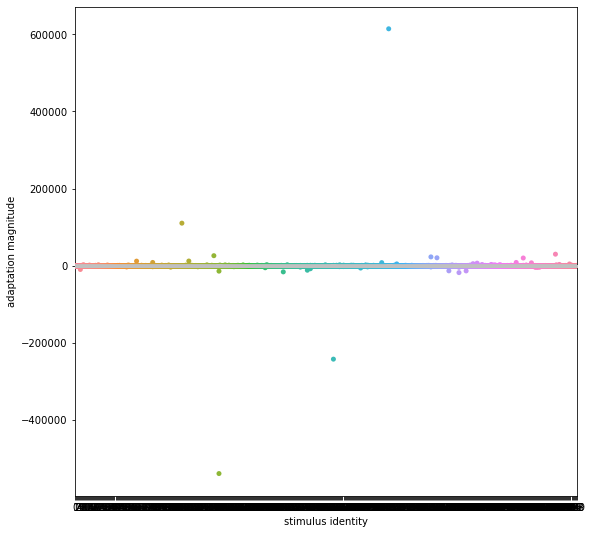

In [26]:
plt.figure(figsize=(9,9))

plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df);

# plt.ylim(-5,5);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

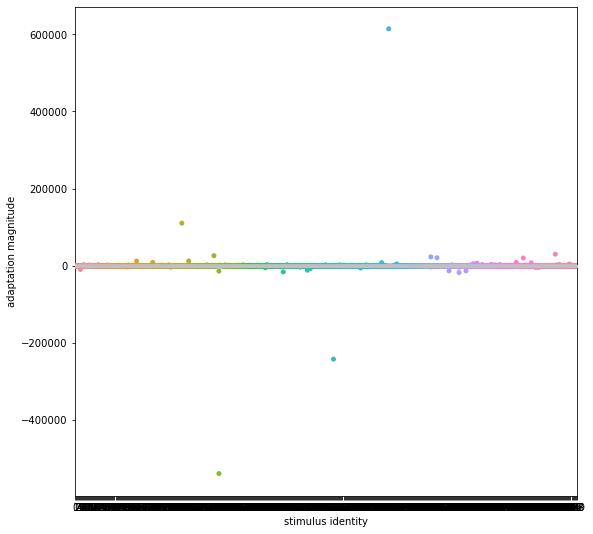

In [27]:
plt.figure(figsize=(9,9))

plt.errorbar(np.arange(nori), mag_mean, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df);

# plt.ylim(-5,5);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

### add dfof_ad thresholding

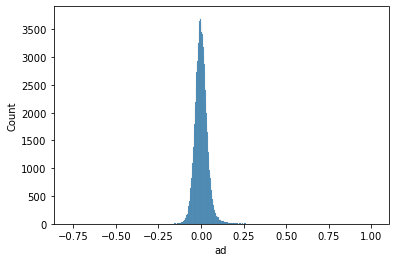

In [28]:
sns.histplot(data=df, x='ad');

In [29]:
sum(df.ad < 0) / len(df) # percent of negative dfof_ad is high bc we did not filter by vis_ad

0.5117084398976982

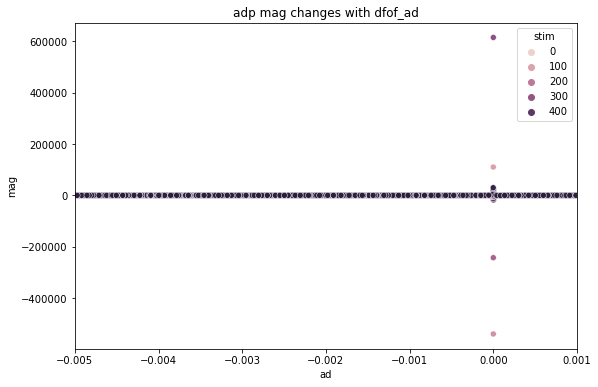

In [30]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df, x="ad", y="mag", hue="stim")
plt.xlim([-0.005,0.001]);
ax.set(title = 'adp mag changes with dfof_ad');

In [193]:
# df2 = df.sort_values(by=['ad'])

# def f(win):
#     plt.figure(figsize=(15,5))
#     plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
#     plt.xlim([-0.002,0.002])
#     plt.xlabel('dfof_ad')
#     plt.ylabel('adaptation mag rolling mean')
#     plt.title('adp mag rolling mean change with dfof_ad of cells')
#     plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [194]:
# df2 = df.sort_values(by=['ad'])

# def f(win):
#     plt.figure(figsize=(15,5))
#     plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).std(), alpha=0.7)
#     plt.xlim([-0.002,0.002])
#     plt.xlabel('dfof_ad')
#     plt.ylabel('adaptation mag rolling std')
#     plt.title('adp mag rolling std change with dfof_ad of cells')
#     plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

cell selection: vis_ad only, with dfof_ad thresholding

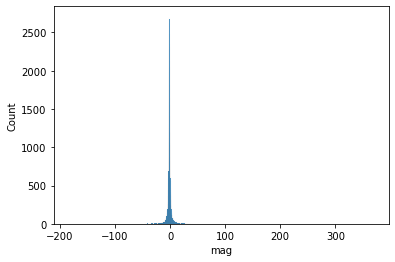

In [33]:
dfof_threshold = 0.0005
df_th = df.copy()
df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan
# sns.histplot(data=df_th, x='mag');

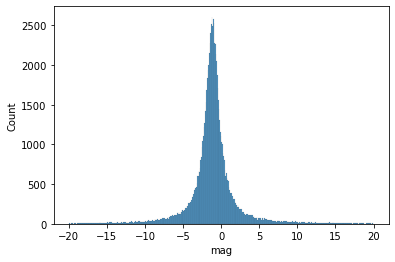

In [35]:
# bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
df_th.loc[df_th[np.abs(df.mag) > 20].index.to_numpy(),'mag'] = np.nan
sns.histplot(data=df_th, x='mag');

In [37]:
df_th[['mag','ad','tg','stim']].groupby(['stim'], sort=False).describe()

mag                                                               \
      count      mean       std        min       25%       50%       75%   
stim                                                                       
0     155.0 -1.061966  3.281144 -11.316357 -2.438239 -0.970813  0.040691   
1     194.0 -1.103515  3.078610 -18.820512 -2.114516 -1.084809 -0.097971   
2     209.0 -1.234477  3.833639 -18.381369 -2.376571 -1.120773 -0.311693   
3     189.0 -0.648552  3.137074 -18.798578 -1.618315 -0.967487 -0.201674   
4     175.0 -0.987213  2.765572  -9.349270 -2.084175 -0.926413  0.001017   
...     ...       ...       ...        ...       ...       ...       ...   
495   176.0 -0.909555  2.848457 -11.858303 -1.959301 -0.971438 -0.248965   
496   167.0 -1.205030  3.049973 -15.145774 -2.482530 -1.083943 -0.098393   
497   189.0 -1.149979  3.567909 -17.860424 -2.222407 -1.211660 -0.464305   
498   182.0 -1.291721  3.242207 -18.851182 -1.994085 -1.093431 -0.261396   
499   195.0 -1.051920  3.412727 -13.184445 -2.234102 -1.310816 -0.263384   

                    ad            ...                         tg            \
            max  count      mean  ...       75%       max  count      mean   
stim                              ...                                        
0     17.386696  391.0 -0.004277  ...  0.015973  0.230382  391.0  0.003682   
1     10.281992  391.0  0.005948  ...  0.025171  0.250427  391.0 -0.000119   
2     16.408041  391.0  0.006037  ...  0.026600  0.423868  391.0  0.001026   
3     12.959980  391.0  0.005627  ...  0.029822  0.550325  391.0  0.005298   
4     11.249057  391.0 -0.002999  ...  0.014673  0.112639  391.0  0.004826   
...         ...    ...       ...  ...       ...       ...    ...       ...   
495   15.230543  391.0 -0.001377  ...  0.021045  0.224466  391.0  0.003901   
496   14.118774  391.0 -0.000299  ...  0.015358  0.209015  391.0 -0.001833   
497   16.095043  391.0  0.002316  ...  0.024818  0.233713  391.0  0.000629   
498   14.820583  391.0  0.001716  ...  0.023178  0.261228  391.0 -0.001084   
499   16.891281  391.0  0.002344  ...  0.022732  0.124394  391.0 -0.003076   

                                                                  
           std       min       25%       50%       75%       max  
stim                                                              
0     0.045634 -0.135916 -0.023950  0.001302  0.027460  0.301438  
1     0.046452 -0.168073 -0.028724 -0.001306  0.022747  0.266527  
2     0.046138 -0.132462 -0.026657 -0.002473  0.023668  0.266218  
3     0.040295 -0.096758 -0.023274  0.000807  0.025578  0.207494  
4     0.033955 -0.088574 -0.014300  0.002329  0.022558  0.208498  
...        ...       ...       ...       ...       ...       ...  
495   0.041912 -0.128589 -0.019123  0.002176  0.021843  0.369137  
496   0.034170 -0.106977 -0.024238 -0.001611  0.020754  0.130681  
497   0.038561 -0.172905 -0.020991  0.001599  0.021096  0.150342  
498   0.035413 -0.117854 -0.025449 -0.003219  0.016970  0.146862  
499   0.030587 -0.089417 -0.025092 -0.003696  0.015415  0.114212  

[500 rows x 24 columns]

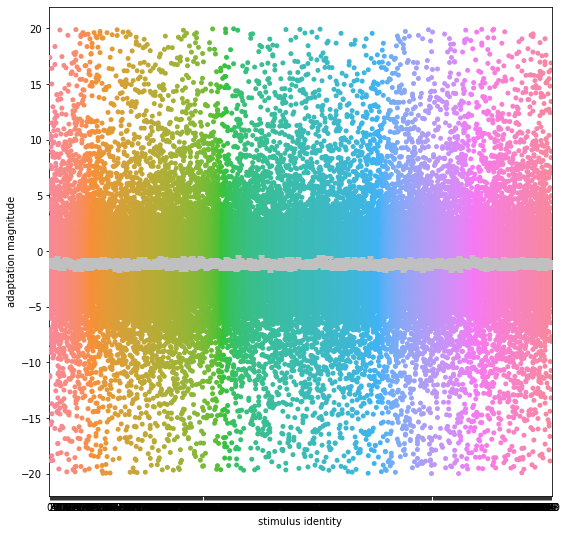

In [38]:
mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df_th);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

In [55]:
mag_sort_id = mag_median.argsort()
mag_median_sorted = mag_median[mag_sort_id[::-1]]
mag_sem_sorted_med = mag_sem[mag_sort_id[::-1]]

mag_sort_id = mag_mean.argsort()
mag_mean_sorted = mag_mean[mag_sort_id[::-1]]
mag_sem_sorted_mean = mag_sem[mag_sort_id[::-1]]

mag_median_sorted[0], mag_median_sorted[-1], mag_mean_sorted[0], mag_mean_sorted[-1]

(-0.6642125840102864,
 -1.520097363750967,
 -0.2728170757441896,
 -1.8724634134816294)

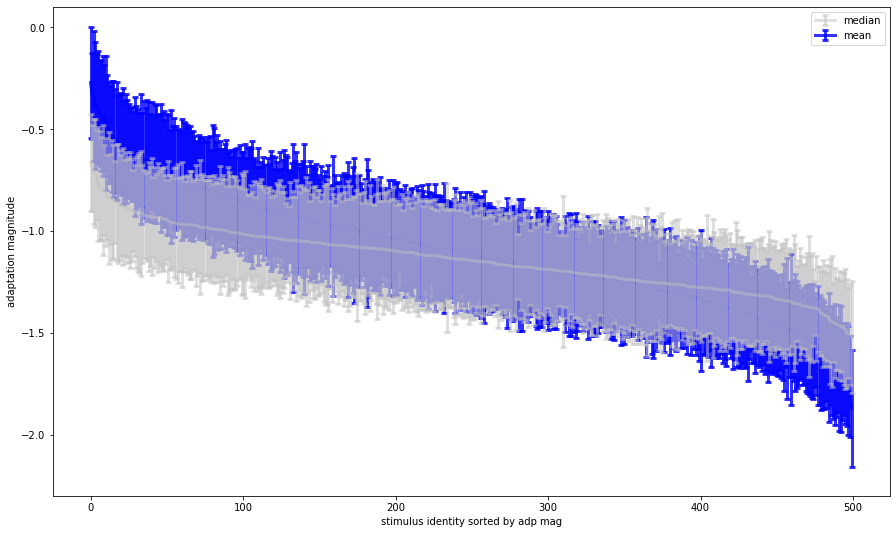

In [70]:
plt.figure(figsize=(15,9))
plt.errorbar(np.arange(nori), mag_median_sorted, yerr=mag_sem_sorted_med, zorder=2, 
             color='silver', linewidth=3, capsize=3, capthick=3, alpha=0.5);
plt.errorbar(np.arange(nori), mag_mean_sorted, yerr=mag_sem_sorted_mean, zorder=1, 
             color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.8);
plt.legend(['median', 'mean'])
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity sorted by adp mag');
plt.ylim(-2.3,0.1);

### dfof_ad & dfof_tg across stims

In [71]:
# df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),['ad','tg','mag']] = np.nan # threshold by dfof_ad
# df_th.tail()

In [72]:
stim_flat_cp = np.concatenate([df_th.stim, df_th.stim])
dfof_flat = np.concatenate([df_th.ad, df_th.tg])
adtg_flat = [['ad','tg']] * df_th.shape[0]
adtg_flat = np.sort([item for sublist in adtg_flat for item in sublist])
df_cp = pd.DataFrame({'stim':stim_flat_cp, 'dfof': dfof_flat, 'ad_or_tg': adtg_flat})
df_cp

,stim,dfof,ad_or_tg
0,0,0.027267,ad
1,0,-0.060858,ad
2,0,-0.027610,ad
3,0,-0.115925,ad
4,0,-0.234697,ad
...,...,...,...
390995,499,0.018908,tg
390996,499,-0.017295,tg
390997,499,0.000773,tg
390998,499,-0.013856,tg


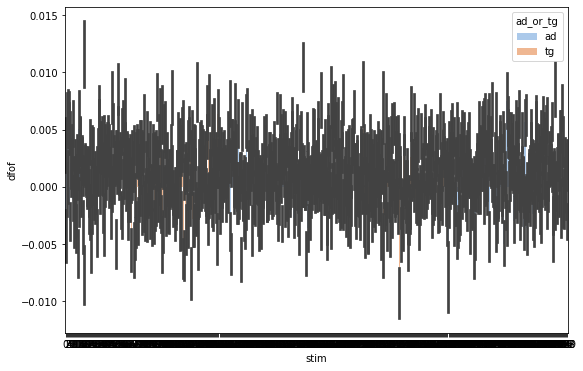

In [73]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x="stim", y="dfof", hue="ad_or_tg", data=df_cp, ci=68, palette="pastel") # mean +- sem

## Trace

In [74]:
trace_mean = np.mean(trace, axis=0)
trace_std = np.std(trace, axis=0)
trace_sem = trace_std / np.sqrt(trace.shape[0])

IndexError: list index out of range

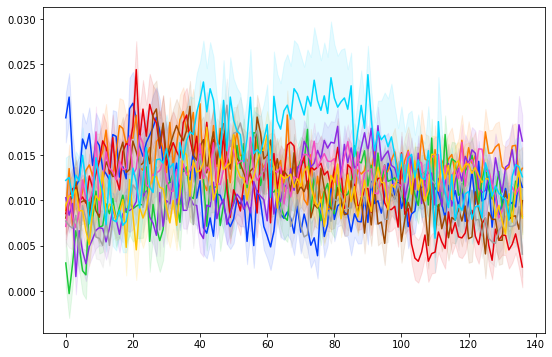

In [75]:
# fig, ax = plt.subplots(figsize=(20,15))
fig, ax = plt.subplots(figsize=(9,6))

for iori in np.arange(nori):
    ax.plot(np.arange(trace.shape[2]), trace_mean[iori,:].flatten(), color=sns.color_palette("bright")[iori])
    ax.fill_between(np.arange(trace.shape[2]), 
                    trace_mean[iori,:].flatten() + trace_sem[iori,:].flatten(), 
                    trace_mean[iori,:].flatten() - trace_sem[iori,:].flatten(),
                    color=sns.color_palette("bright")[iori], alpha=0.1)
plt.grid('minor')
plt.ylim(-0.02,0.10)
plt.xlabel('frame number')
plt.ylabel('dfof')
plt.show()